In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 72.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.7 MB/s 

# Import Libraries
1.This section imports all necessary libraries:

2.PyTorch and its modules for deep learning

3.Torchvision for computer vision models and datasets

4.NumPy for numerical operations

5.Matplotlib for visualization

6.PIL for image processing

7.Grad-CAM related libraries for model interpretability

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from PIL import Image
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# Device Setup

Sets up the device to use GPU if available, otherwise falls back to CPU.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Mount Google Drive
Mounts Google Drive to access the dataset (specific to Google Colab environment).

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

# Dataset Paths
Defines paths to training and testing datasets.

In [ ]:
data_loc = r'/content/drive/MyDrive/MRI'
TRAIN_ROOT = "/content/drive/MyDrive/MRI/Training"
TEST_ROOT = "/content/drive/MyDrive/MRI/Testing"

# Data Transformations
1.Defines image transformations:

2.Resize to 255x255 pixels

3.Convert to PyTorch tensor
Normalize with ImageNet mean and std (standard for pretrained models)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((255, 255)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load Datasets
Loads training and testing datasets using ImageFolder, which automatically organizes images by class.

In [ ]:
train_dataset = ImageFolder(root=TRAIN_ROOT, transform=transform)
test_dataset = ImageFolder(root=TEST_ROOT, transform=transform)

# Create Data Loaders
Creates data loaders for batch processing during training/testing.

In [ ]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Get Number of Classes
Determines the number of classes from the training dataset.

In [ ]:
num_classes = len(train_dataset.classes)

# Define CNN Model
1.Defines a custom CNN model:

2.Uses pretrained VGG16 as backbone

3.Replaces the last fully connected layer to match the number of classes in the dataset

In [ ]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.vgg16 = models.vgg16(pretrained=True)
        in_features = self.vgg16.classifier[6].in_features
        self.vgg16.classifier[6] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.vgg16(x)

# Initialize Model
Creates an instance of the model and moves it to the selected device (GPU/CPU).

In [ ]:
model = CNNModel(num_classes).to(device)

# Define Loss and Optimizer
1.Uses CrossEntropy loss (standard for classification)

2.Uses Adam optimizer with learning rate 0.00001

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Training Loop
1.Defines the training process:

2.Runs for specified number of epochs

3.For each batch: moves data to device, clears gradients, computes forward pass, calculates loss, performs backpropagation, updates weights

4.Prints epoch progress and average loss

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

# Train the Model
Executes the training process.

In [ ]:
train_model(model, criterion, optimizer)

# Prediction and Visualization Function

**This function:**

1.Loads and preprocesses an image

2.Makes a prediction using the trained model

3.Generates Grad-CAM visualization to show which parts of the image were important for the prediction

4.Displays both the original image and the Grad-CAM heatmap side by side

In [ ]:
def predict_and_visualize(image_path):
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Predict
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)
        predicted_class = predicted.item()

    # Get class label
    class_labels = test_dataset.classes
    pred_label = class_labels[predicted_class]

    print("Predicted label for this image:", pred_label)

    # Grad-CAM
    target_layers = [model.vgg16.features[-1]]
    cam = GradCAM(model=model, target_layers=target_layers)
    targets = [ClassifierOutputTarget(predicted_class)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]

    # Visualization
    visualization = show_cam_on_image(np.array(image.resize((255, 255))) / 255., grayscale_cam, use_rgb=True)

    # Show results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(visualization)
    plt.title("Grad-CAM")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')
    plt.show()

Using device: cuda:0
Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 146MB/s]


Epoch 1/10, Loss: 0.7723
Epoch 2/10, Loss: 0.3241
Epoch 3/10, Loss: 0.2006
Epoch 4/10, Loss: 0.1137
Epoch 5/10, Loss: 0.0603
Epoch 6/10, Loss: 0.0370
Epoch 7/10, Loss: 0.0231
Epoch 8/10, Loss: 0.0126
Epoch 9/10, Loss: 0.0086
Epoch 10/10, Loss: 0.0202


# Prediction

Enter the path to the image file (e.g., /content/drive/MyDrive/MRI/image.jpg): /content/image(2).jpg
Predicted label for this image: meningioma_tumor


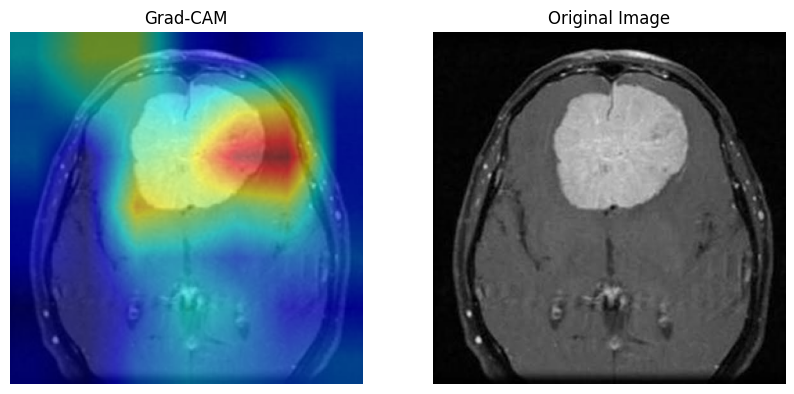

In [ ]:
# Function to get image path from user
def upload_image():
    image_path = input("Enter the path to the image file (e.g., /content/drive/MyDrive/MRI/image.jpg): ")
    return image_path

# Main execution
if __name__ == "__main__":
    image_path = upload_image()
    predict_and_visualize(image_path)